In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")
from functools import partial
from typing import Literal

import uproot
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

from analyzer.dumperReader.reader import *
from analyzer.driver.fileTools import *
from analyzer.driver.computations import *
from analyzer.computations.CPToSupercls import CPToSuperclusterProperties
from analyzer.computations.tracksters import tracksters_seedProperties, CPtoTrackster_properties
from analyzer.energy_resolution.fit import *

In [2]:
input_dfs_path = "/grid_mnt/data_cms_upgrade/cuisset/supercls/alessandro_electrons/supercls-v14-dnn/final-dfs"
CPtoSC_DNN_df, CPtoSC_mustache_df = pd.read_pickle(input_dfs_path + "/CPToSupercluster_recoSC.pkl.gz"), pd.read_pickle(input_dfs_path + "/CPToSupercluster_fwlite.pkl.gz")

In [8]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
histedges_equalN(CPtoTs_df.raw_pt, 8)

array([  0.19099887,  10.6431818 ,  21.76990128,  33.47890854,
        44.89075089,  56.28796005,  67.90643311,  80.21333313,
       100.76296234])

In [3]:
h_scOverCP_energy_DNN = make_scOrTsOverCP_energy_histogram(name="scOverCP_energy", label="Supercluster energy / CaloParticle energy")
fill_scOverCP_energy_histogram(h_scOverCP_energy_DNN, CPtoSC_DNN_df)
h_scOverCP_energy_DNN

Hist(
  Regular(500, 0, 2, name='e_ratio', label='Supercluster energy / CaloParticle energy'),
  Variable([1.65, 2.15, 2.75], name='absSeedEta', label='|eta|seed'),
  Variable([0.443104, 11.5899, 23.0052, 34.5857, 46.8587, 58.3225, 68.9698, 80.8003, 97.7474], name='seedPt', label='Seed Et (GeV)'),
  storage=Double()) # Sum: 5751.0 (5759.0 with flow)

In [10]:
h_scOverCP_energy_mustache = make_scOrTsOverCP_energy_histogram(name="scOverCP_energy", label="Supercluster energy / CaloParticle energy")
fill_scOverCP_energy_histogram(h_scOverCP_energy_mustache, CPtoSC_mustache_df)
h_scOverCP_energy_mustache

Hist(
  Regular(500, 0, 2, name='e_ratio', label='Supercluster energy / CaloParticle energy'),
  Variable([1.65, 2.15, 2.75], name='absSeedEta', label='|eta|seed'),
  Variable([0.443104, 11.5899, 23.0052, 34.5857, 46.8587, 58.3225, 68.9698, 80.8003, 97.7474], name='seedPt', label='Seed Et (GeV)'),
  storage=Double()) # Sum: 5759.0 (5766.0 with flow)

In [11]:
scOverCP_fit_DNN = fitMultiHistogram(h_scOverCP_energy_DNN)
scOverCP_fit_mustache = fitMultiHistogram(h_scOverCP_energy_mustache)

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs/analyzer/energy_resolution/../../analyzer/energy_resolution/fit.py:46: RuntimeWarning: overflow encountered in exp
  return A* np.exp(-dx*dx/f)
/grid_mnt/vol_home/llr/cms/cuisset/hgcal/supercls/repoForJobs/analyzer/energy_resolution/../../analyzer/energy_resolution/fit.py:46: RuntimeWarning: overflow encountered in multiply
  return A* np.exp(-dx*dx/f)


In [7]:
def plotSingleHistWithFit(h_1d:hist.Hist, fitRes:CruijffFitResult, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))
    hep.histplot([h_1d], label=["Best associated\nsupercluster", "Best associated trackster"], ax=ax, yerr=False, flow="none")
    x_plotFct = np.linspace(h_1d.axes[0].centers[0], h_1d.axes[0].centers[-1], 500)
    ax.plot(x_plotFct, cruijff(x_plotFct,*fitRes.params.makeTuple()), label=f"Cruijff fit\n$\sigma={fitRes.params.sigmaAverage:.3f}$")
    ax.set_xlim(0.5, 1.5)
    ax.set_ylabel("Events")
    ax.legend()
    hep.cms.text("Preliminary", exp="TICLv5", ax=ax)
    hep.cms.lumitext("PU=200", ax=ax)

In [8]:
def plotAllFits(h:hist.Hist, fitResults:list[list[CruijffFitResult]]):
    for eta_bin in range(len(h.axes["absSeedEta"])):
        for seedPt_bin in range(len(h.axes["seedPt"])):
            h_1d = h[{"absSeedEta":eta_bin, "seedPt":seedPt_bin}]
            plotSingleHistWithFit(h_1d, fitResults[eta_bin][seedPt_bin])
            plt.text(0.05, 0.95, etaBinToText(eta_bin)+"\n"+ptBinToText(seedPt_bin), va="top", transform=plt.gca().transAxes, fontsize=20)

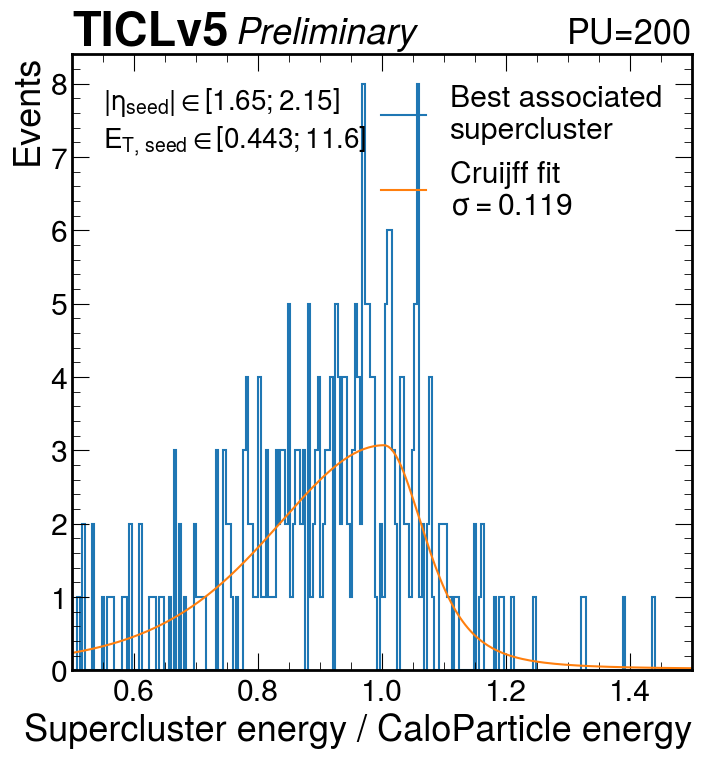

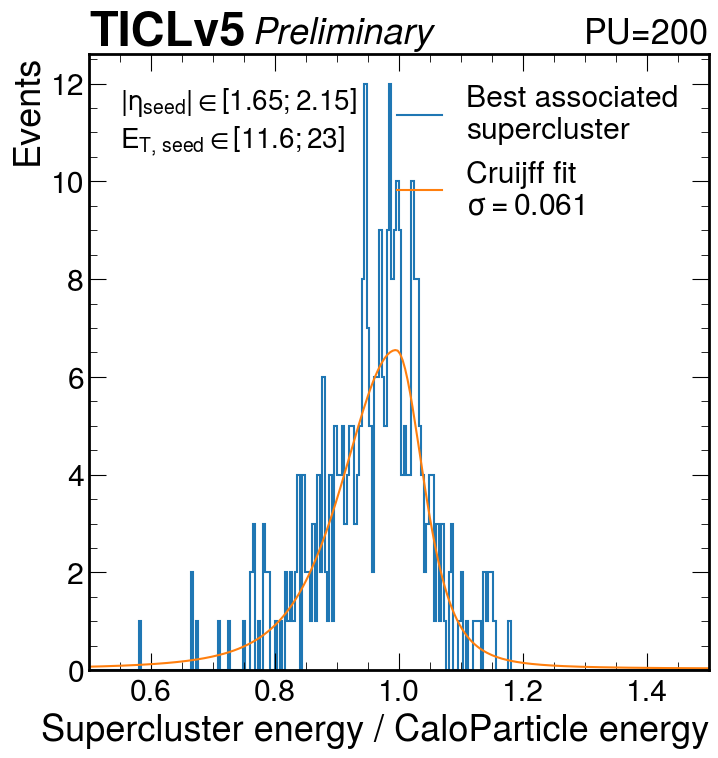

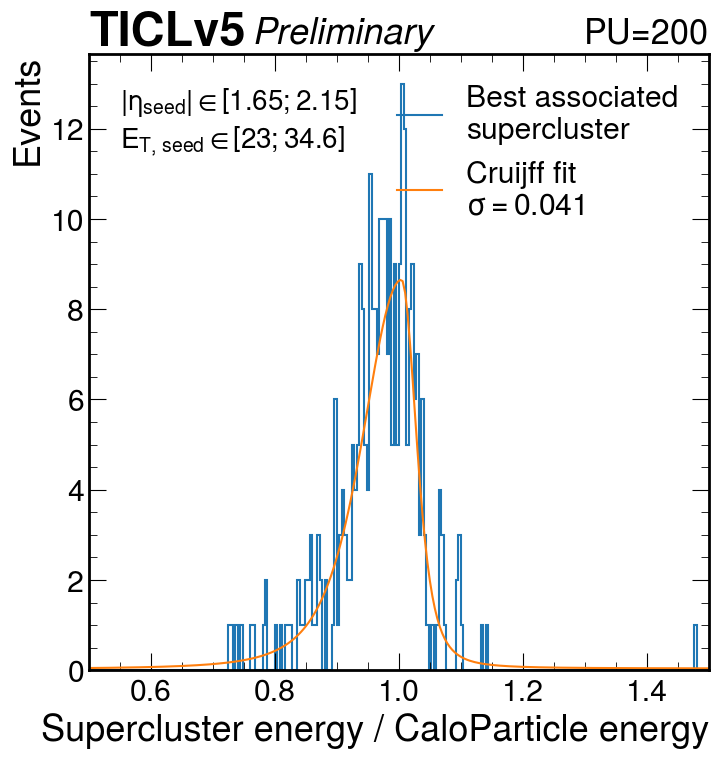

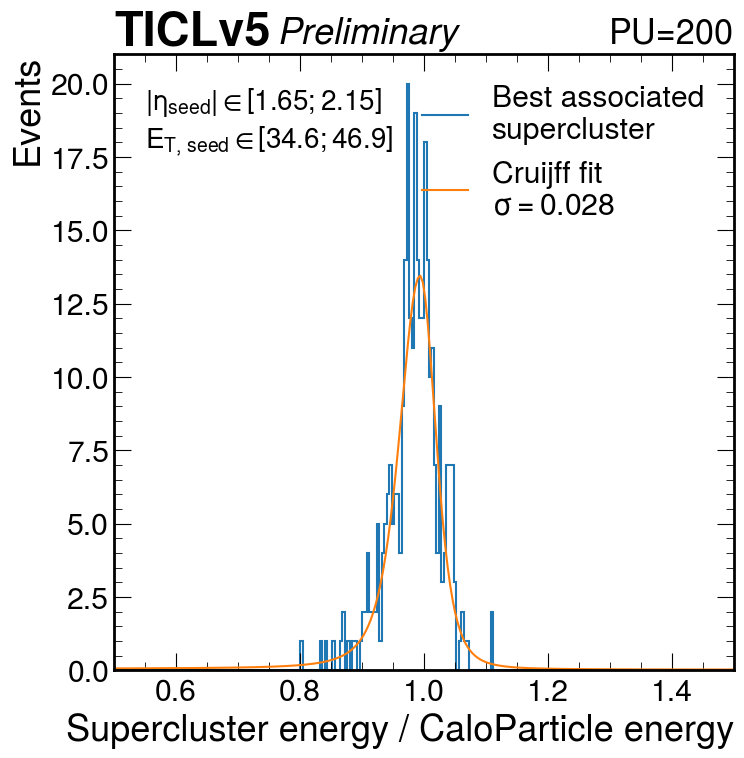

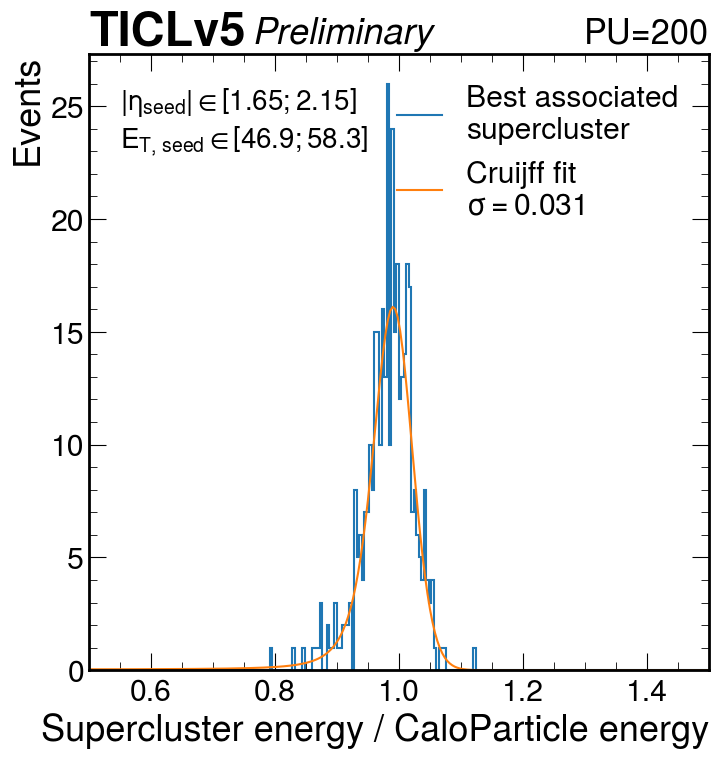

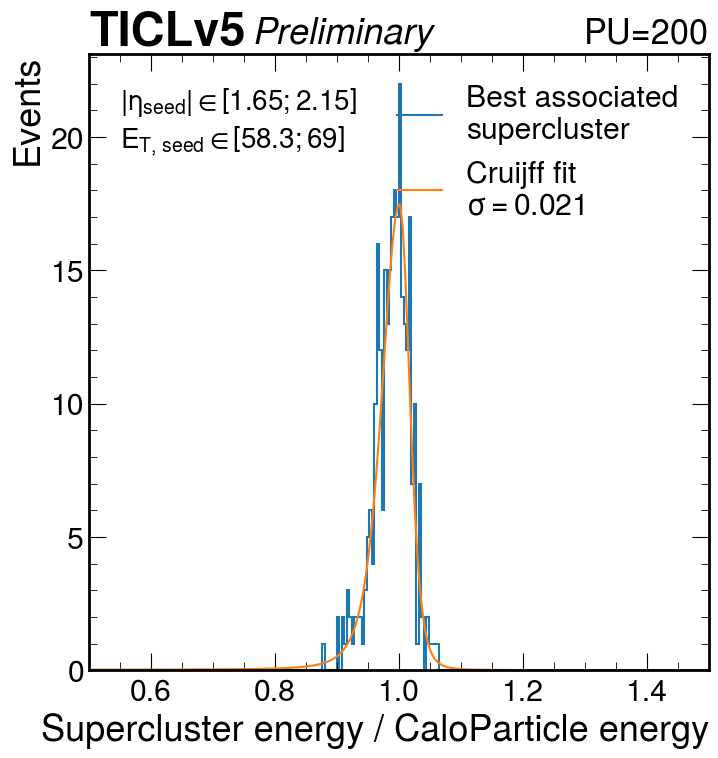

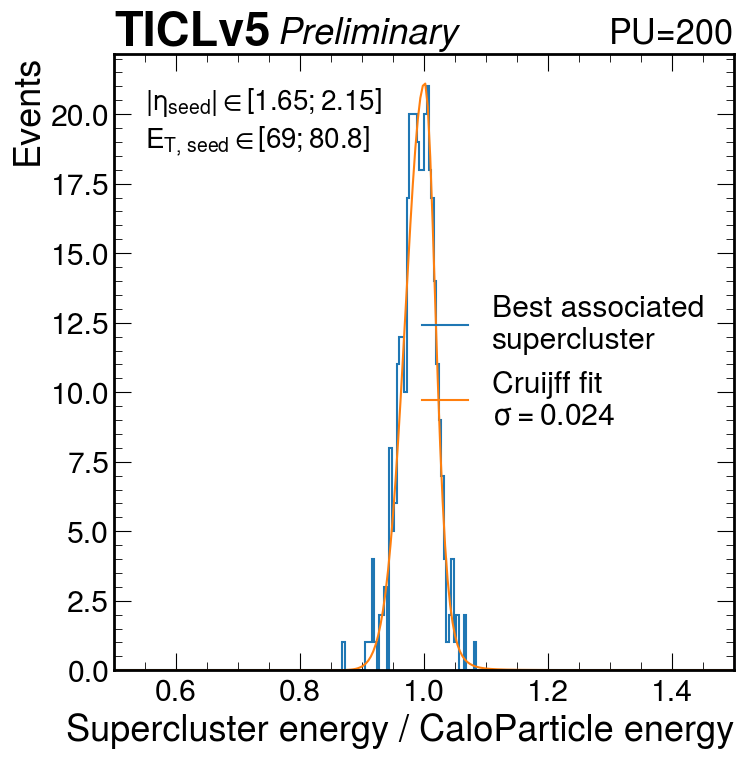

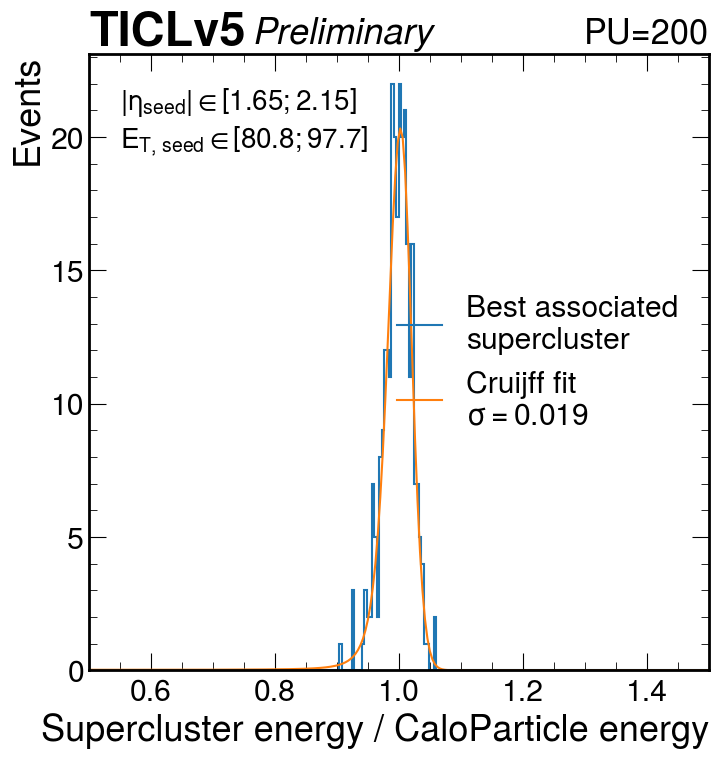

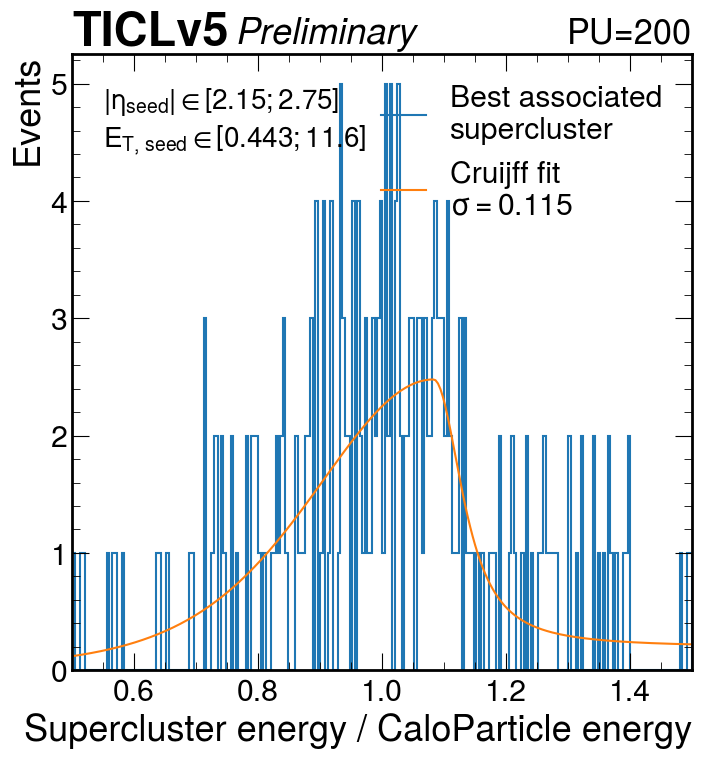

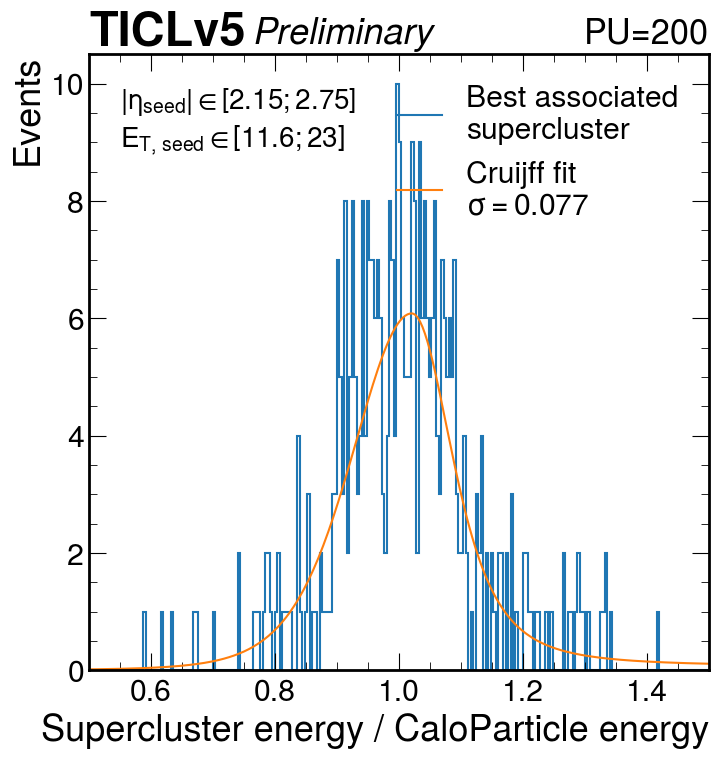

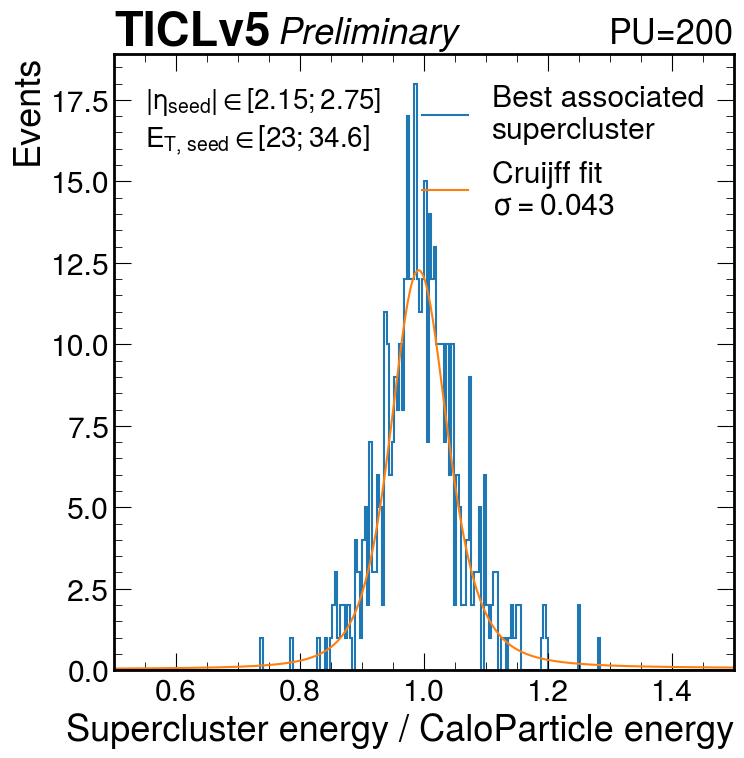

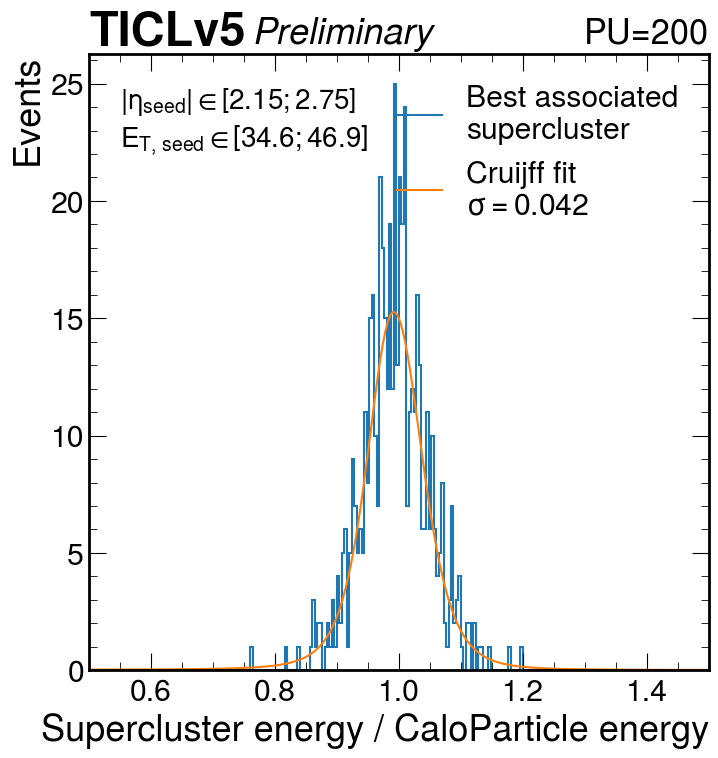

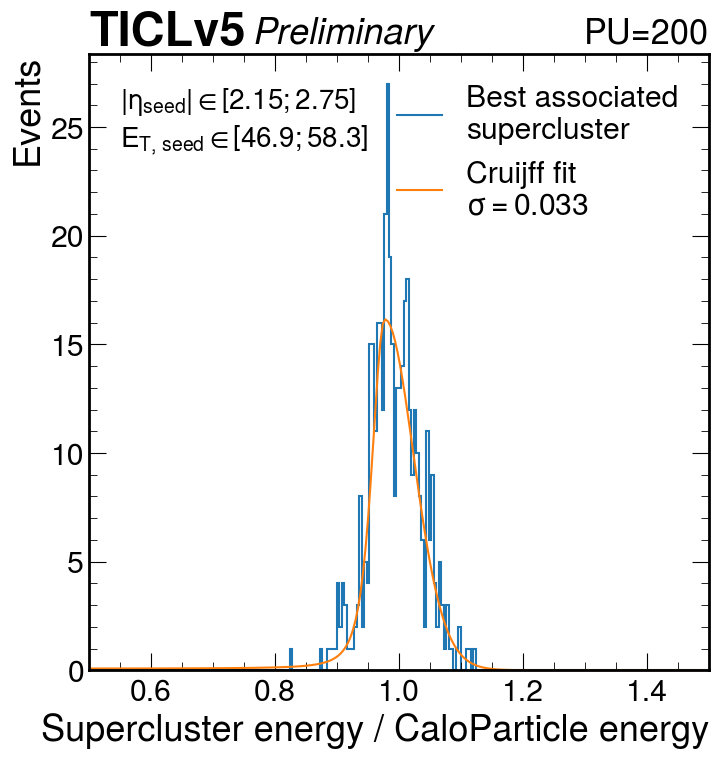

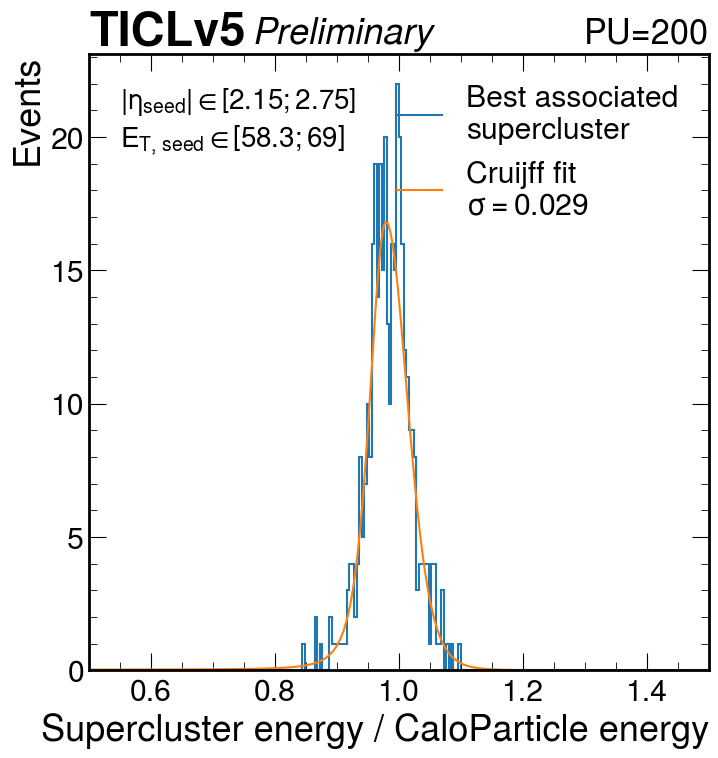

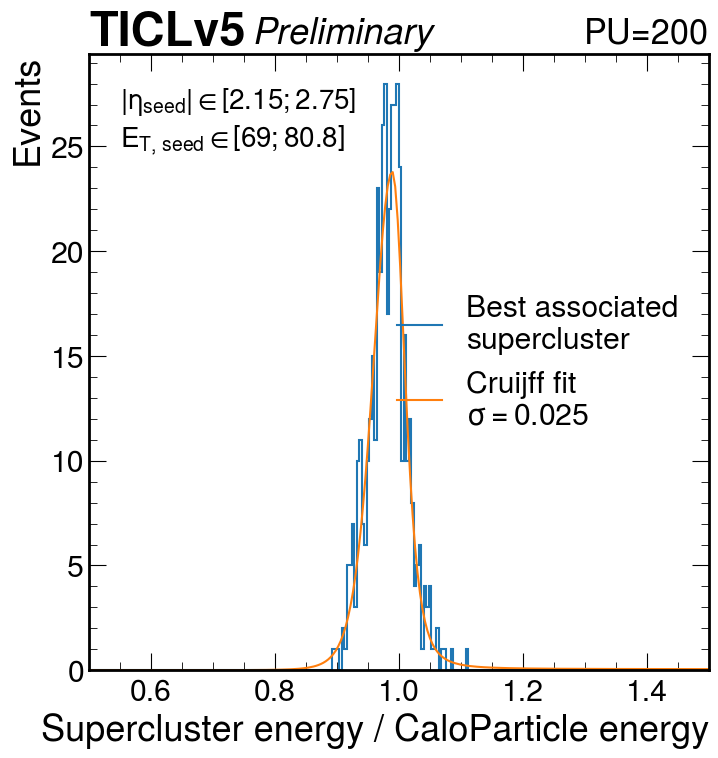

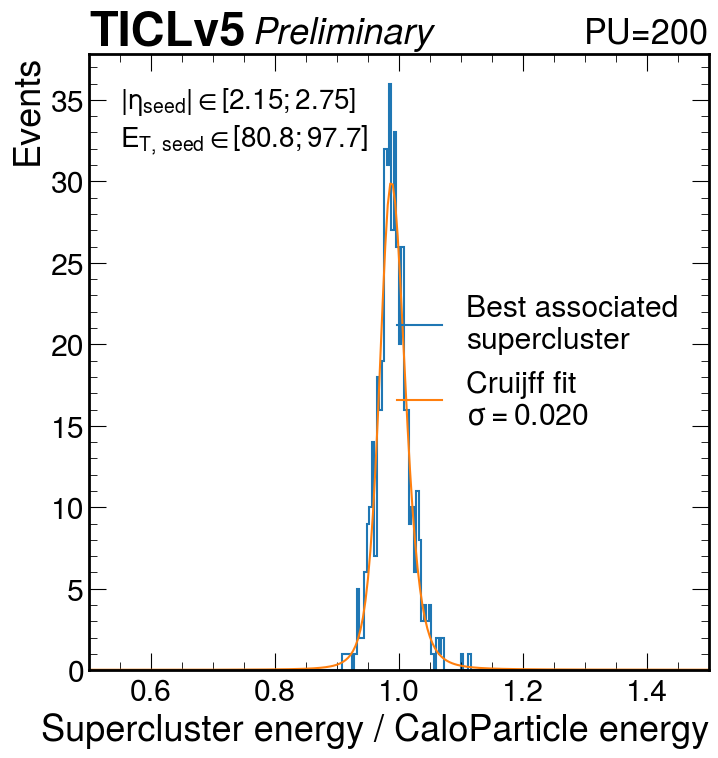

In [12]:
plotAllFits(h_scOverCP_energy_DNN, scOverCP_fit_DNN)

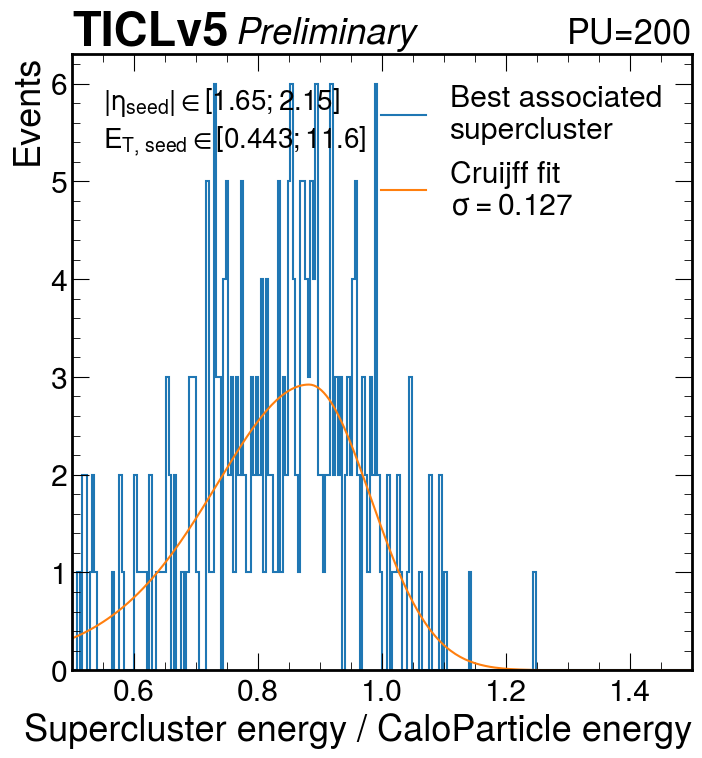

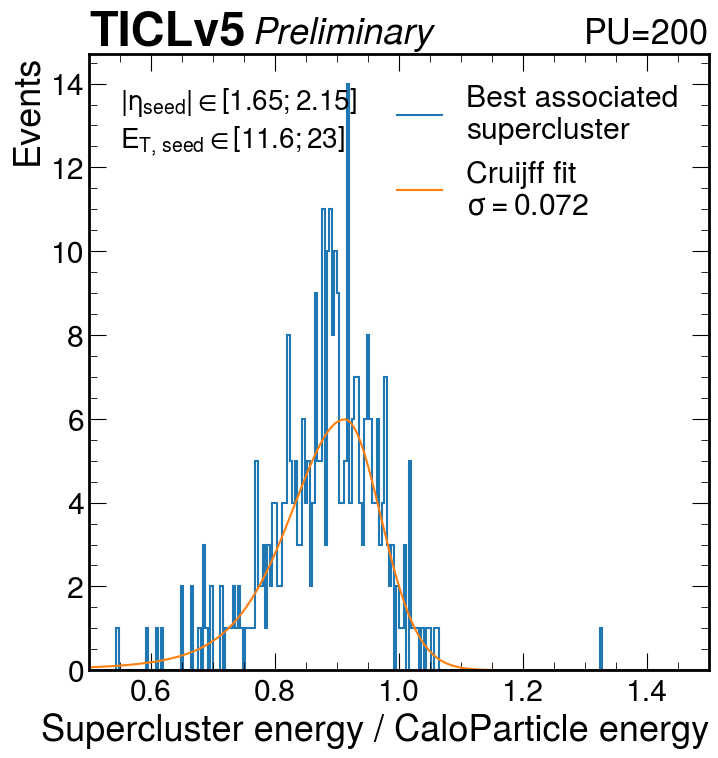

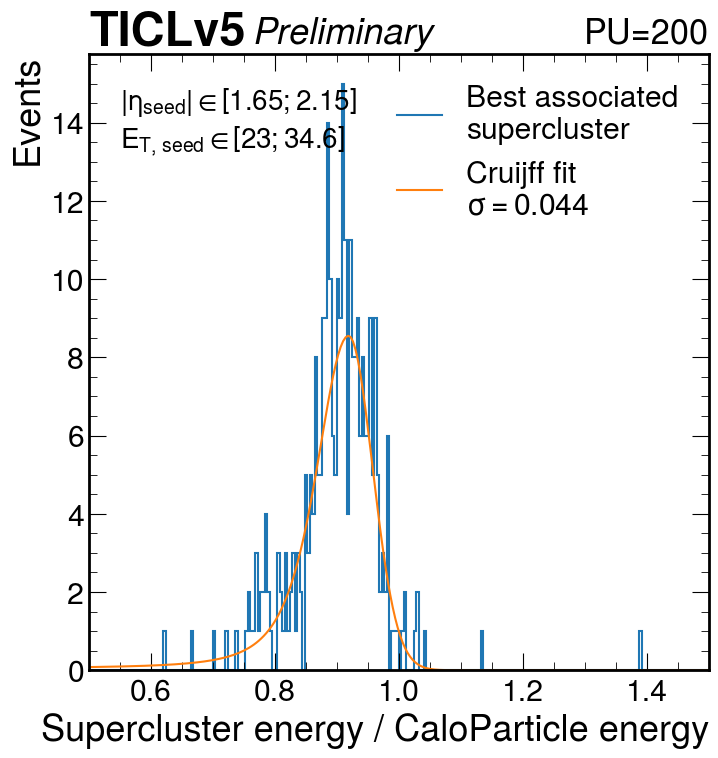

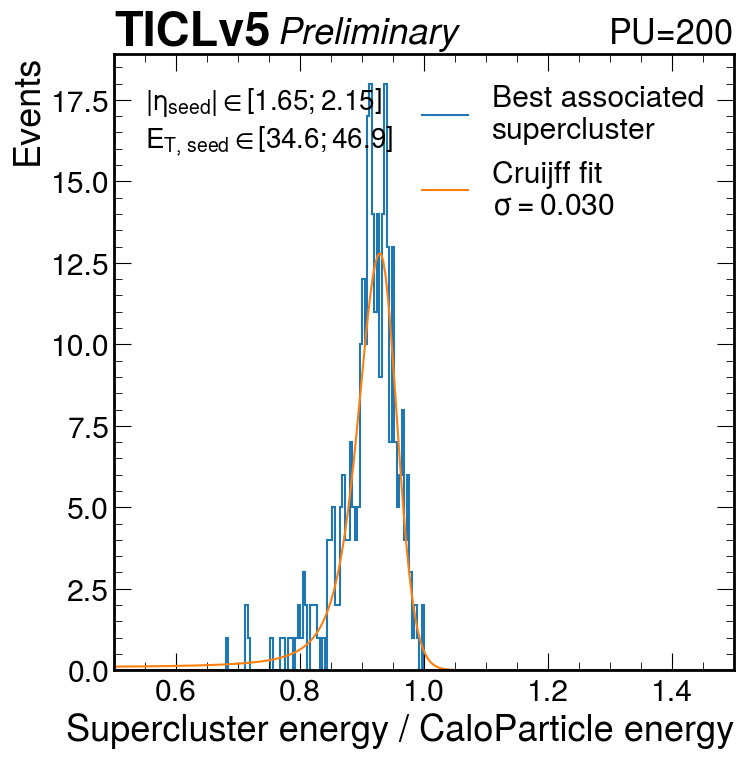

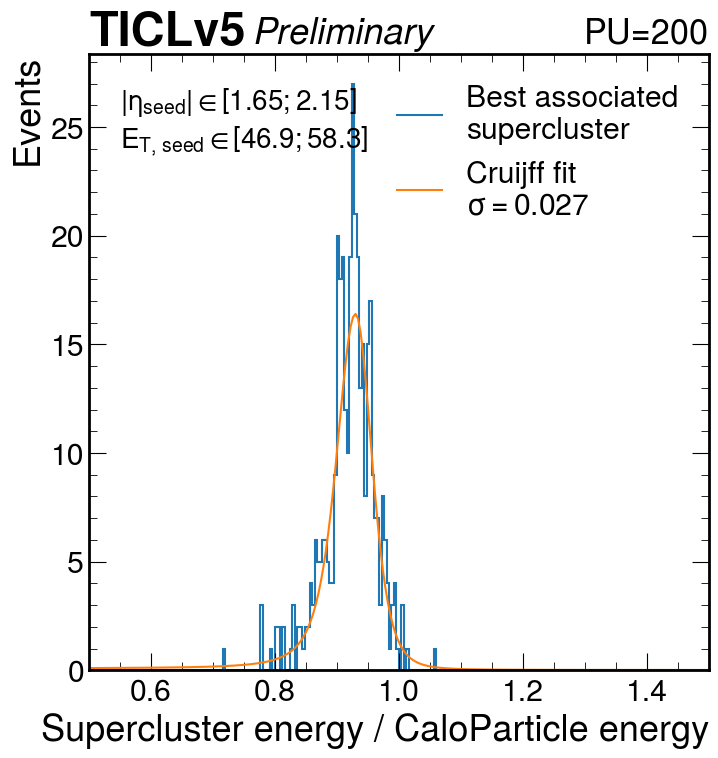

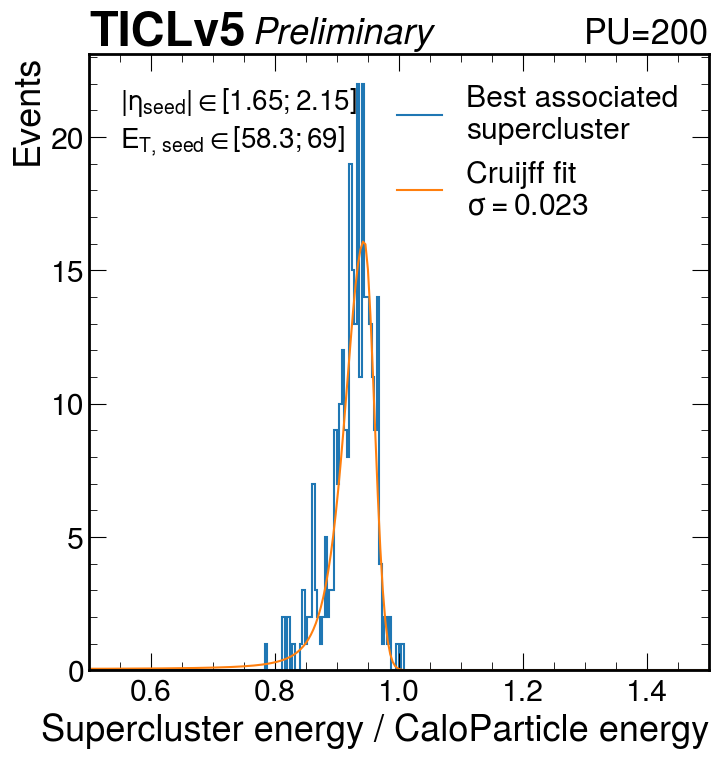

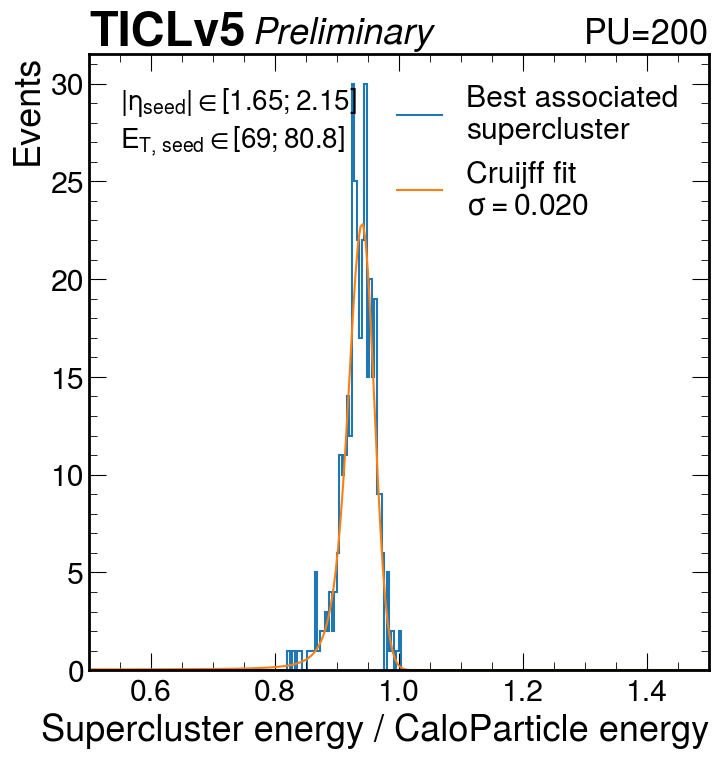

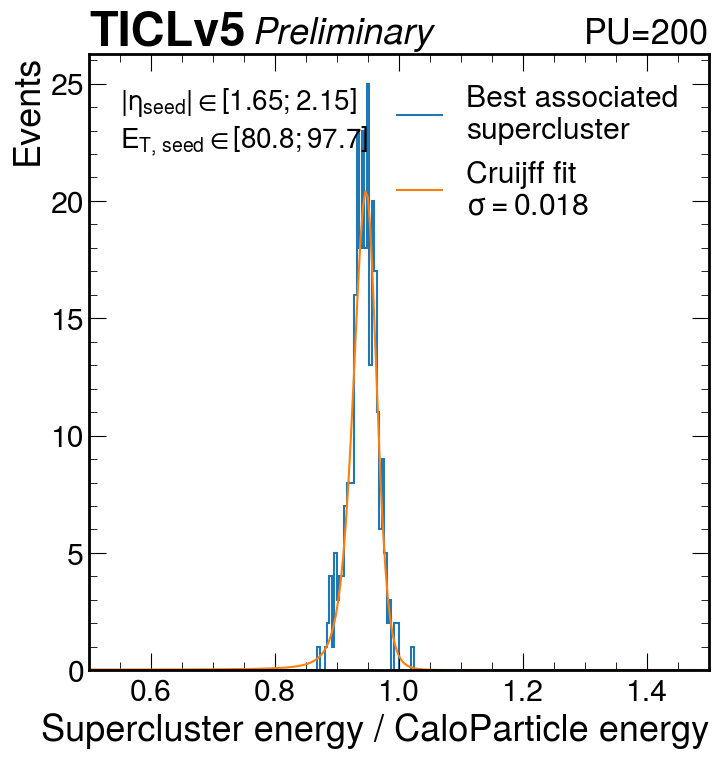

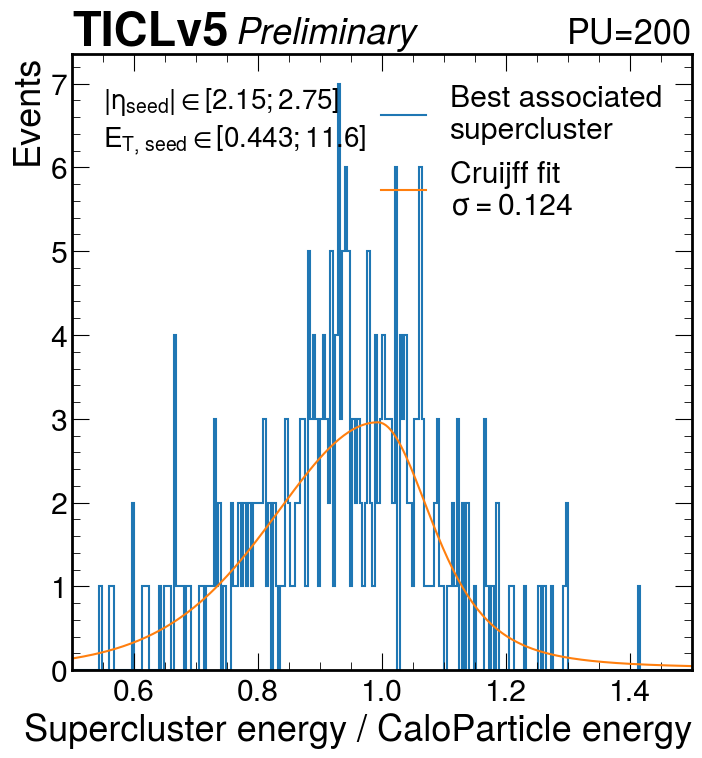

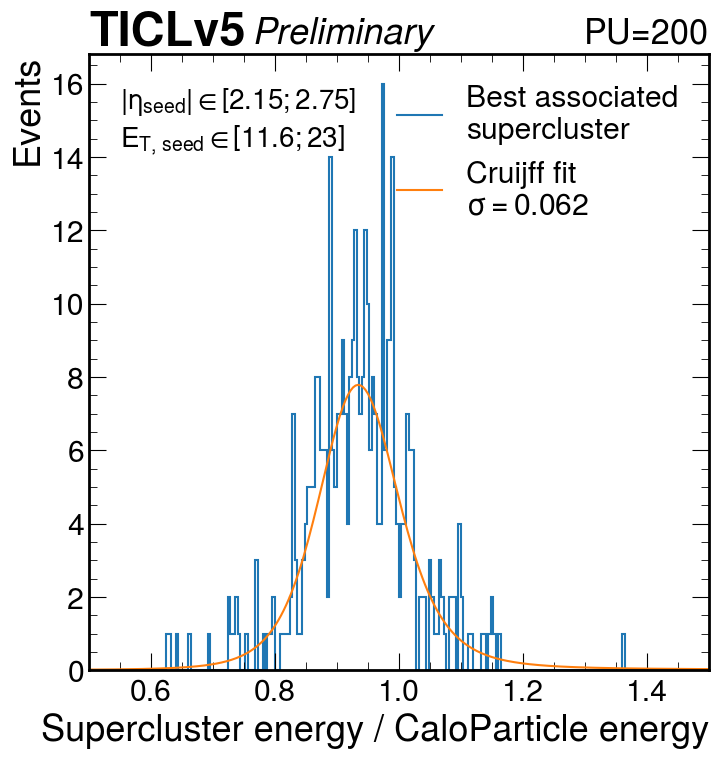

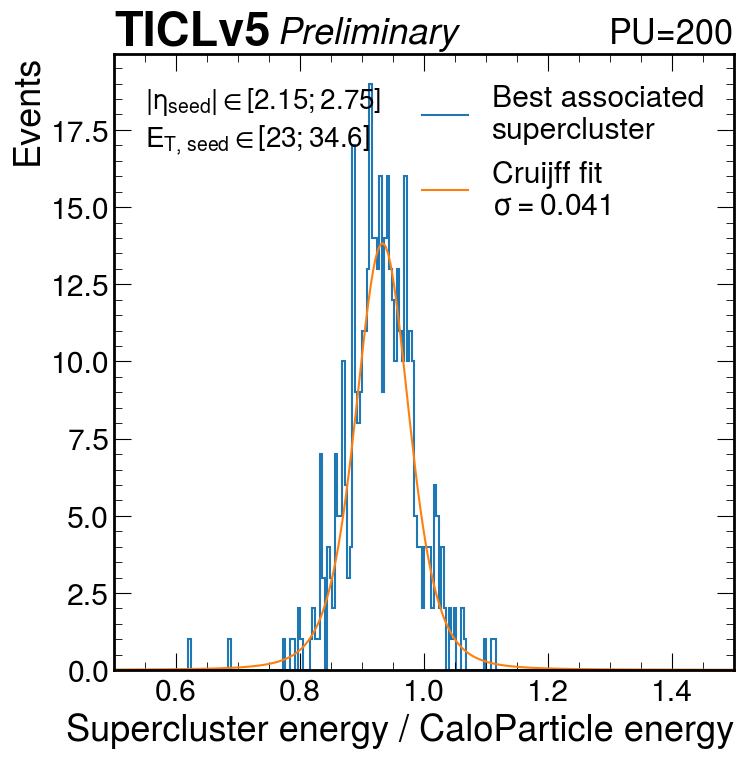

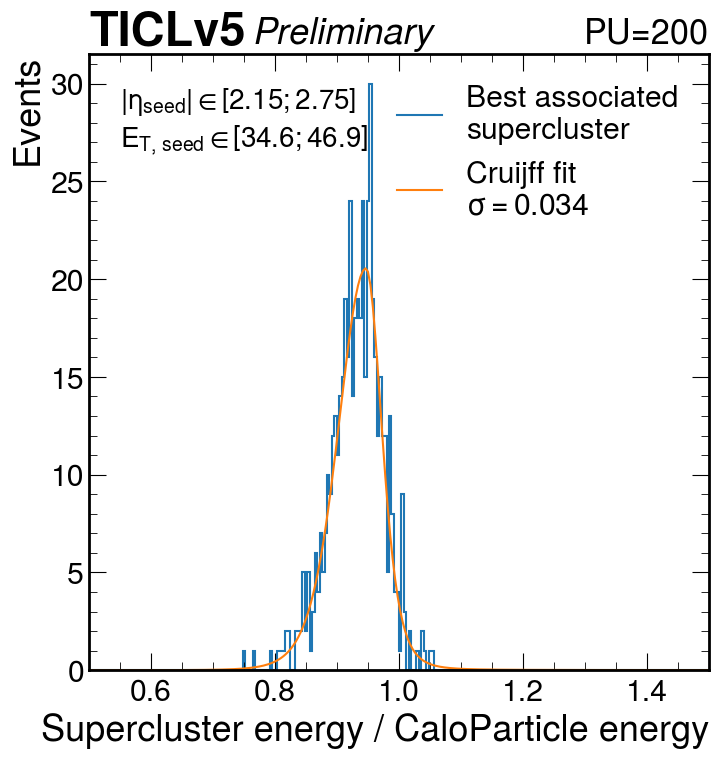

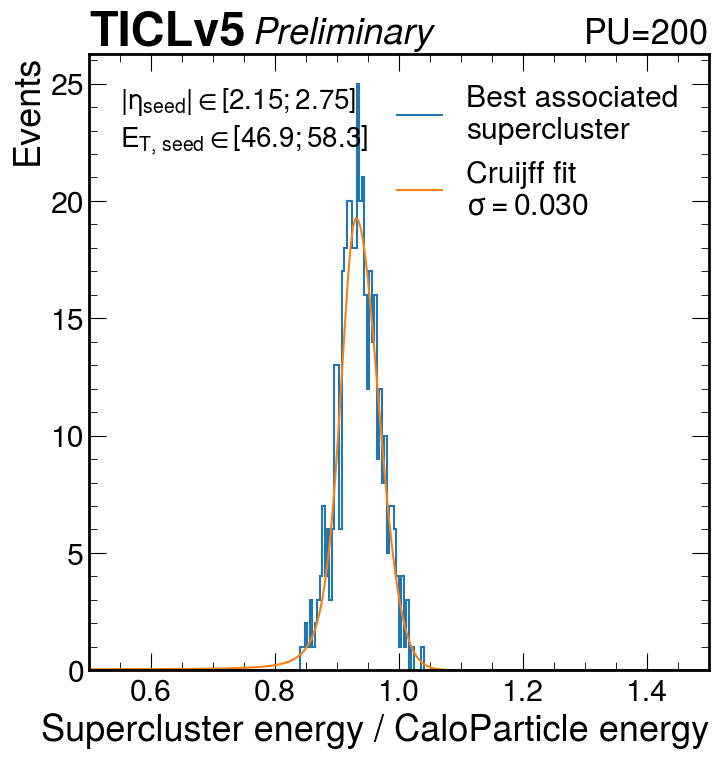

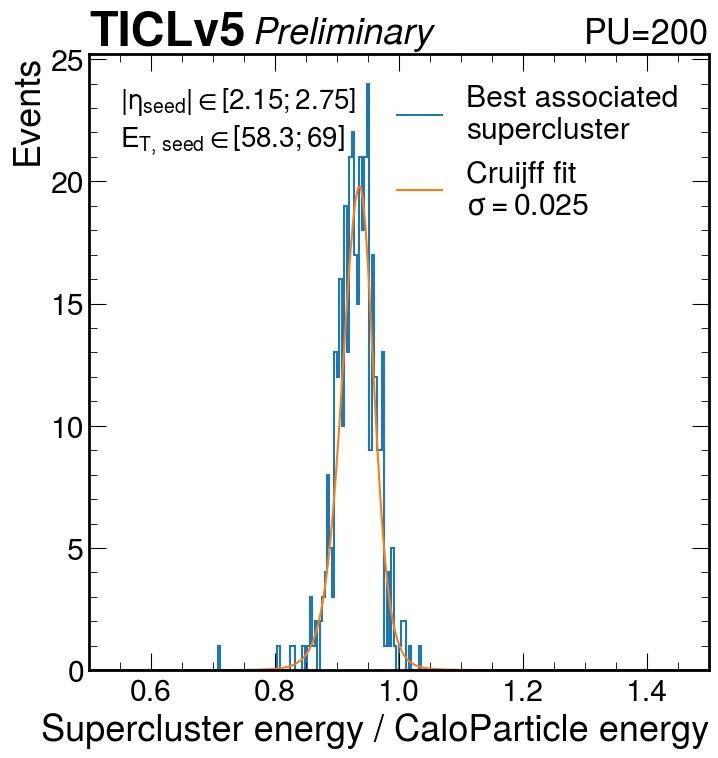

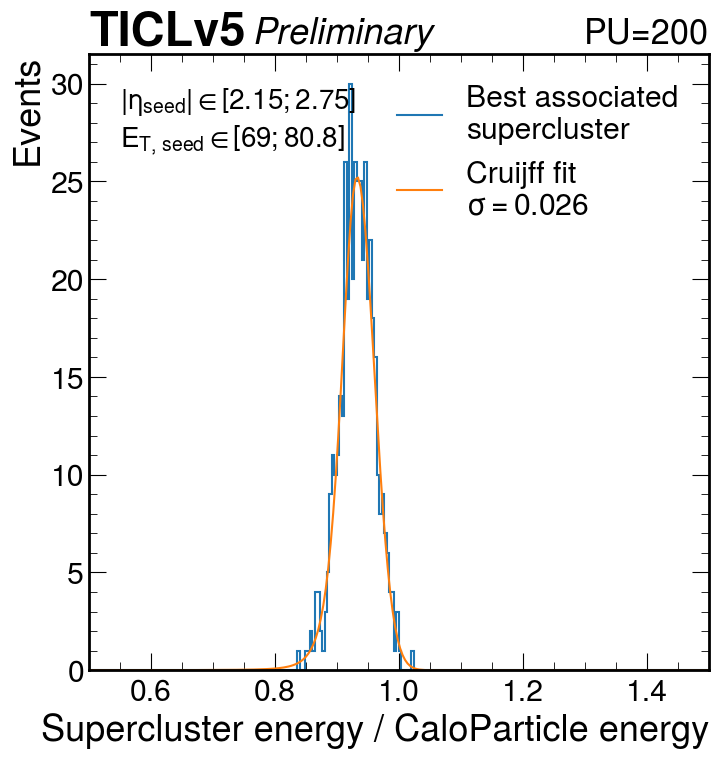

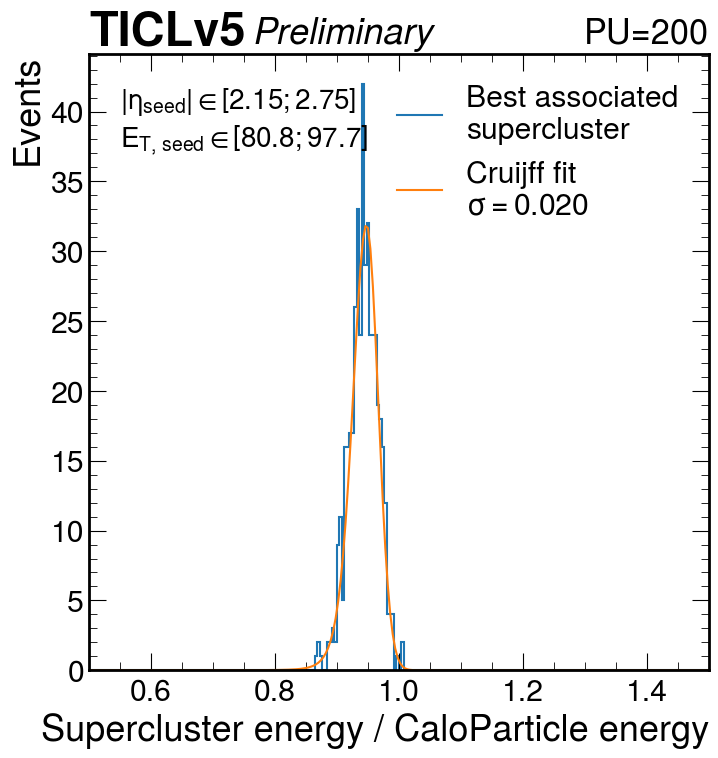

In [13]:
plotAllFits(h_scOverCP_energy_mustache, scOverCP_fit_mustache)

In [14]:
def plotResolution_compareWithSeed(fitRes:dict[str, list[list[CruijffFitResult]]], legendLabel:dict[str, str]=None, 
              plotMode:Literal["sigma", "mu"]="sigma", ratio:bool=False,
              colors_eta=['tab:blue', 'tab:red', 'tab:green', 'tab:purple'],
              errorbar_common_kwargs=dict(markeredgewidth=1.5, capsize=5, lw=1.5),
              errorbar_individual_kwargs=[ dict(fmt='.', markersize=10), dict(fmt='s', markersize=8, mfc='w'),]):
    """ 
    Plot resolution comparing using the seed trackster and using the supercluster
    Parameters : (typeOfData is scOverCP or tsOverCP)
     - fitRes is dict : typeOfData -> 2D list eta*Et of CruiffFitResult
     - legendLabel : dict : typeOfData -> legend label for typeOfData
     - plotMode : plot sigma or mu
    """
    if legendLabel is None:
        legendLabel = {typeOfData : typeOfData for typeOfData in fitRes}
    if ratio:
        assert len(fitRes) == 2, "Ratio mode requires excatly 2 plots"
        fig = plt.figure(figsize=(8, 10))
        grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])
        main_ax = fig.add_subplot(grid[0])
        ratio_ax = fig.add_subplot(grid[1], sharex=main_ax)
        plt.setp(main_ax.get_xticklabels(), visible=False)
        if plotMode == "sigma":
            ratio_ax.set_ylabel(r'$\sigma_{DNN} / \sigma_{mainTs}$')
        elif plotMode == "mu":
            ratio_ax.set_ylabel(r'$\mu_{DNN} / \mu_{mainTs}$')
        ratio_ax.axhline(y=1, color='gray', linestyle='--')
        ratio_ax.set_xlabel("Seed $p_T$ (GeV)")
    else:
        fig, main_ax = plt.subplots(figsize=(9, 8))
        main_ax.set_xlabel("Seed $p_T$ (GeV)")
    
    
    for eta_bin in range(len(eta_axis)):
        #for seedPt_bin in range(len(h.axes["seedPt"])):
        yvals_list = []
        xerr_vals = []
        for i, (typeOfData, currentFitResults) in enumerate(fitRes.items()):
            if i == 0:
                xerr = seedPt_axis.widths/2
                xerr_vals.append(xerr)
            else:
                xerr = None
            if plotMode == "sigma":
                yvals = [res.params.sigmaAverage for res in currentFitResults[eta_bin]]
            elif plotMode == "mu":
                yvals = [res.params.m for res in currentFitResults[eta_bin]]
            main_ax.errorbar(seedPt_axis.centers, yvals, xerr=xerr, 
                **(dict(color=colors_eta[eta_bin])|errorbar_common_kwargs|errorbar_individual_kwargs[i]))
            yvals_list.append(yvals)
            #main_ax.errorbar(seedPt_axis.centers, [res.params.sigmaAverage for res in currentFitResults[eta_bin]], xerr=seedPt_axis.widths/2, fmt='.', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=10, color=colors_eta[eta_bin])
            #axs[0].errorbar(bins_mean, sigma_v2, fmt='s', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=8, color=colors_eta[b], mfc='w')
        if ratio:
            ratio_vals = np.array(yvals_list[1])/np.array(yvals_list[0])
            ratio_ax.errorbar(seedPt_axis.centers, ratio_vals, xerr=xerr_vals[0], fmt='x', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=8,
                color=colors_eta[eta_bin])
        #makeRatio(main_ax,inset_axs0, sigma_v2, sigma_mous, colors_eta[b], bins_mean, bins_width, False)
        ## For the legend
        main_ax.errorbar([], [], xerr = [], **(dict(color=colors_eta[eta_bin])|errorbar_common_kwargs|errorbar_individual_kwargs[0]), label=etaBinToText(eta_bin))
    
    for typeOfData, errorbar_kwargs in zip(fitRes.keys(), errorbar_individual_kwargs): # legend
        main_ax.errorbar([], [], xerr = [], **errorbar_kwargs, color='black', label=legendLabel[typeOfData])
    main_ax.legend()
    if plotMode == "sigma":
        main_ax.set_ylabel(r'$\sigma(E_{SC}/E_{GEN})$')
    elif plotMode == "mu":
        main_ax.set_ylabel(r'$\mu(E_{SC}/E_{GEN})$')
    hep.cms.text("Preliminary", exp="TICLv5", ax=main_ax)
    hep.cms.lumitext("PU=200", ax=main_ax)

def plotResolution_compareSC(fitRes:dict[str, list[list[CruijffFitResult]]], legendLabel:dict[str, str]=None, 
              plotMode:Literal["sigma", "mu"]="sigma", ratio:bool=False,
              colors_eta=['tab:blue', 'tab:red', 'tab:green', 'tab:purple'],
              errorbar_common_kwargs=dict(markeredgewidth=1.5, capsize=5, lw=1.5),
              errorbar_individual_kwargs=[ dict(fmt='.', markersize=10), dict(fmt='s', markersize=8, mfc='w'),]):
    """ 
    Plot resolution comparing DNN/mustache
    Parameters : (typeOfData is DNN/mustache)
     - fitRes is dict : typeOfData -> 2D list eta*Et of CruiffFitResult
     - legendLabel : dict : typeOfData -> legend label for typeOfData
     - plotMode : plot sigma or mu
    """
    if legendLabel is None:
        legendLabel = {typeOfData : typeOfData for typeOfData in fitRes}
    if ratio:
        assert len(fitRes) == 2, "Ratio mode requires excatly 2 plots"
        fig = plt.figure(figsize=(8, 10))
        grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])
        main_ax = fig.add_subplot(grid[0])
        ratio_ax = fig.add_subplot(grid[1], sharex=main_ax)
        plt.setp(main_ax.get_xticklabels(), visible=False)
        if plotMode == "sigma":
            ratio_ax.set_ylabel(r'$\sigma_{DNN} / \sigma_{mainTs}$')
        elif plotMode == "mu":
            ratio_ax.set_ylabel(r'$\mu_{DNN} / \mu_{mainTs}$')
        ratio_ax.axhline(y=1, color='gray', linestyle='--')
        ratio_ax.set_xlabel("Seed $p_T$ (GeV)")
    else:
        fig, main_ax = plt.subplots(figsize=(9, 8))
        main_ax.set_xlabel("Seed $p_T$ (GeV)")
    
    
    for eta_bin in range(len(eta_axis)):
        #for seedPt_bin in range(len(h.axes["seedPt"])):
        yvals_list = []
        xerr_vals = []
        for i, (typeOfData, currentFitResults) in enumerate(fitRes.items()):
            if i == 0:
                xerr = seedPt_axis.widths/2
                xerr_vals.append(xerr)
            else:
                xerr = None
            if plotMode == "sigma":
                yvals = [res.params.sigmaAverage for res in currentFitResults[eta_bin]]
            elif plotMode == "mu":
                yvals = [res.params.m for res in currentFitResults[eta_bin]]
            main_ax.errorbar(seedPt_axis.centers, yvals, xerr=xerr, 
                **(dict(color=colors_eta[eta_bin])|errorbar_common_kwargs|errorbar_individual_kwargs[i]))
            yvals_list.append(yvals)
            #main_ax.errorbar(seedPt_axis.centers, [res.params.sigmaAverage for res in currentFitResults[eta_bin]], xerr=seedPt_axis.widths/2, fmt='.', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=10, color=colors_eta[eta_bin])
            #axs[0].errorbar(bins_mean, sigma_v2, fmt='s', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=8, color=colors_eta[b], mfc='w')
        if ratio:
            ratio_vals = np.array(yvals_list[1])/np.array(yvals_list[0])
            ratio_ax.errorbar(seedPt_axis.centers, ratio_vals, xerr=xerr_vals[0], fmt='x', markeredgewidth=1.5, capsize=5, lw=1.5, markersize=8,
                color=colors_eta[eta_bin])
        #makeRatio(main_ax,inset_axs0, sigma_v2, sigma_mous, colors_eta[b], bins_mean, bins_width, False)
        ## For the legend
        main_ax.errorbar([], [], xerr = [], **(dict(color=colors_eta[eta_bin])|errorbar_common_kwargs|errorbar_individual_kwargs[0]), label=etaBinToText(eta_bin))
    
    for typeOfData, errorbar_kwargs in zip(fitRes.keys(), errorbar_individual_kwargs): # legend
        main_ax.errorbar([], [], xerr = [], **errorbar_kwargs, color='black', label=legendLabel[typeOfData])
    main_ax.legend()
    if plotMode == "sigma":
        main_ax.set_ylabel(r'$\sigma(E_{SC}/E_{GEN})$')
    elif plotMode == "mu":
        main_ax.set_ylabel(r'$\mu(E_{SC}/E_{GEN})$')
    hep.cms.text("Preliminary", exp="TICLv5", ax=main_ax)
    hep.cms.lumitext("PU=200", ax=main_ax)


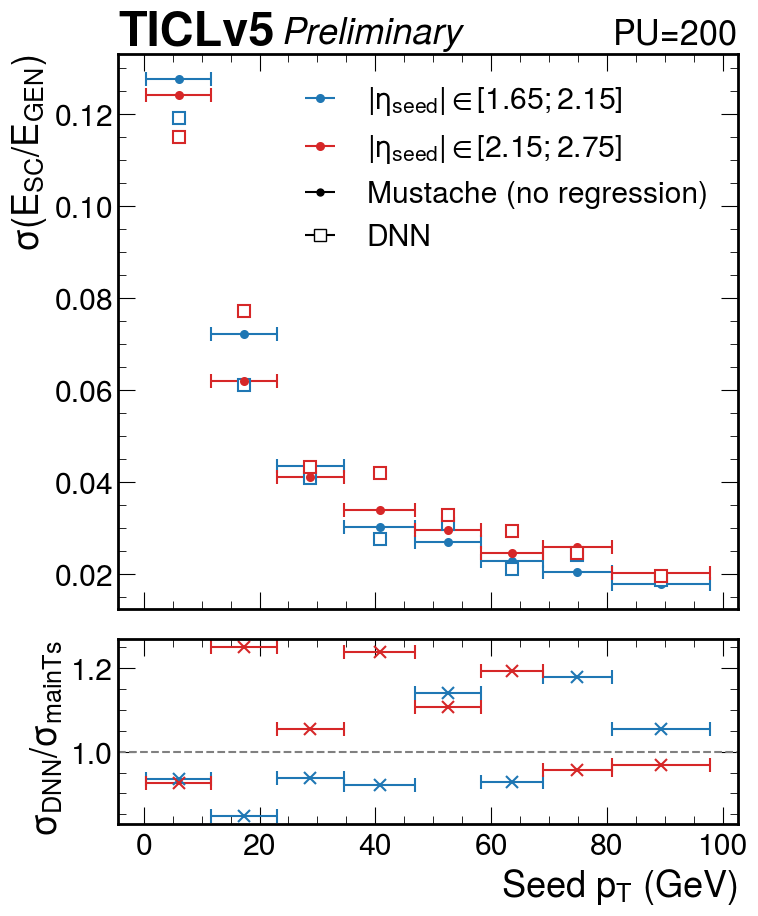

In [18]:
plotResolution_compareSC({"mustache": scOverCP_fit_mustache, "DNN":scOverCP_fit_DNN}, legendLabel={"DNN" : "DNN", "mustache" : "Mustache (no regression)"},
    ratio=True)

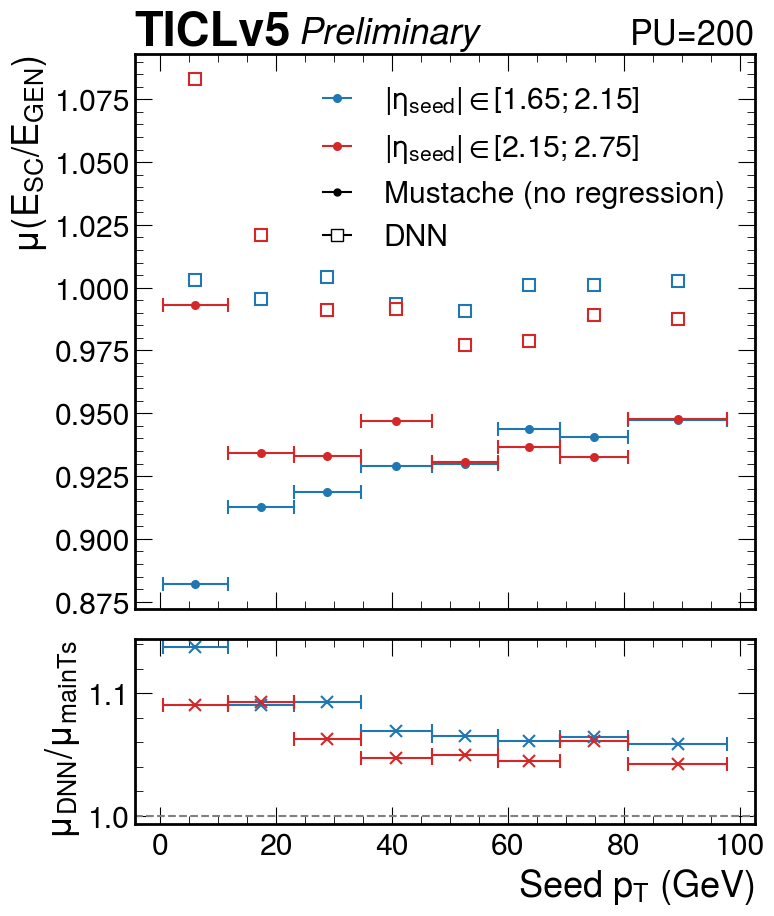

In [19]:
plotResolution_compareSC({"mustache": scOverCP_fit_mustache, "DNN":scOverCP_fit_DNN}, legendLabel={"DNN" : "DNN", "mustache" : "Mustache (no regression)"},
    ratio=True, plotMode="mu")